## Installing Libraries

In [ ]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00


# IMPORTING REQUIRED LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import KFold
from xgboost import XGBRFRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

In [ ]:
import plotly.graph_objects as go
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import *
from xgboost.sklearn import XGBRegressor


# LOADING DATASET
As input information I have two useful CSV files:

* **Housing_dataset_train.csv** - training part of the dataset, contains labels and information about passengers.
* **Housing_dataset_test.csvv** - testing part of the dataset, doesn't contain labels.

First, load both csv files into two DataFrames, using pandas read_csv method.

In [ ]:
# path to train dataset
train_path = "/content/drive/MyDrive/DSNAIB/Housing_dataset_train.csv"
# path to test dataset
test_path = "/content/drive/MyDrive/DSNAIB/Housing_dataset_test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# DESCRIPTIVE ANALYSIS

In [ ]:
# shape of tha data
print('Train shape: ', train_data.shape)
print('Test shape: ', test_data.shape)

Train shape:  (14000, 7)
Test shape:  (6000, 6)


The training data contains information 14000, described by 6 variables, including 1 target variable.  
The testing data contains 6000 observations, i.e information about house prices, described by 6 variables (the test dataset doesn't contain target value.)

Combine test and train data into one "all_data" DataFrame.   
To do so, I create a sequence of DataFrame objects and use pandas concat method. Terget values of testing data in resulting dataset will be NaN.  
Check the shape of the result DataFrame and take a look at the first 4 rows:

In [ ]:
# create a sequence of DataFrame objects
frames = [train_data, test_data]
# Concatenate pandas objects along a particular axis
all_data = pd.concat(frames, sort = False)
# shape of the data
print('All data shape: ', all_data.shape)
# Show first 4 rows of the concatenated DataFrame
all_data.head(4)

All data shape:  (20000, 7)


ID      loc                 title  bedroom  bathroom  parking_space  \
0  3583  Katsina  Semi-detached duplex      2.0       2.0            1.0   
1  2748     Ondo             Apartment      NaN       2.0            4.0   
2  9261    Ekiti                   NaN      7.0       5.0            NaN   
3  2224  Anambra       Detached duplex      5.0       2.0            4.0   

         price  
0  1149999.565  
1  1672416.689  
2  3364799.814  
3  2410306.756

Checking for Duplicates in the combined data

In [ ]:
all_data.duplicated().sum()

0

## Types of the variables

Data types, non-null values count:

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             20000 non-null  int64  
 1   loc            18187 non-null  object 
 2   title          18278 non-null  object 
 3   bedroom        18201 non-null  float64
 4   bathroom       18195 non-null  float64
 5   parking_space  18189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
train_data.columns

Index(['ID', 'loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')

In [ ]:
train_data.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [ ]:
train_data.describe()

ID       bedroom      bathroom  parking_space         price
count  14000.000000  12201.000000  12195.000000   12189.000000  1.400000e+04
mean    4862.700357      4.308171      3.134235       3.169825  2.138082e+06
std     3818.348214      2.441165      2.035950       1.599415  1.083057e+06
min        0.000000      1.000000      1.000000       1.000000  4.319673e+05
25%     1672.750000      2.000000      1.000000       2.000000  1.393990e+06
50%     3527.000000      4.000000      2.000000       3.000000  1.895223e+06
75%     8011.250000      6.000000      5.000000       4.000000  2.586699e+06
max    12999.000000      9.000000      7.000000       6.000000  1.656849e+07

# EXPLORATORY ANALYSIS

## UNIVARIATE ANALYSIS

## Visualizing the `Price` - TARGET VALUE
Let's calculate and visualise distribution of our target variable - `Price`.  

### Using Histogram to Check for skewness

In [ ]:
# Create a histogram for the price variable
fig = px.histogram(all_data, x="price", title="Histogram of House Prices")

# Customize the layout of the chart
fig.update_layout(
    yaxis_title="Frequency",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=False),  # Hide gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
    width=800,  # Set the width of the plot in pixels
    height=600,  # Set the height of the plot in pixels
)


# Show the histogram
fig.show()

### Using Box-Plot for detecting Outliers in Price feature

In [ ]:
# Create the Plotly box plot
# Create the box trace
fig = go.Figure()

# Add the box trace
fig.add_trace(
    go.Box(
        y=all_data['price'],  # Price values on the y-axis
        boxpoints='outliers',  # Display only the outliers as individual points
        jitter=0.3,  # Add jitter to the points for better visibility
        marker_color='royalblue',  # Customize the color of the box and points
        line_color='black',  # Customize the color of the box lines
        opacity=0.7,  # Set the opacity of the box and points
    )
)

# Customize the layout of the chart
fig.update_layout(
    title="Box Plot for Price Summary Statistics",
    yaxis_title="Price",
    boxmode='group',  # Display the boxes in a group mode
    showlegend=False,  # Hide the legend
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=False),  # Hide gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
)

# Show the plot
fig.show()


## Visualizing the Location Feature

In [ ]:
test_data['loc'].value_counts()

Benue          188
Borno          188
Ogun           185
Oyo            183
Anambra        180
Kogi           177
Abia           175
Katsina        175
Bauchi         175
Adamawa        175
Lagos          174
Nasarawa       172
Ekiti          170
Kebbi          170
Kano           170
Delta          169
Osun           168
Taraba         167
Ondo           167
Kaduna         166
Zamfara        165
Edo            165
Cross River    163
Sokoto         163
Enugu          159
Plateau        159
Bayelsa        159
Niger          159
Yobe           159
Gombe          158
Akwa Ibom      155
Jigawa         155
Imo            152
Ebonyi         147
Kwara          144
Rivers         144
Name: loc, dtype: int64

In [ ]:
train_data['loc'].value_counts()

Kaduna         370
Anambra        363
Benue          355
Yobe           353
Borno          351
Kano           351
Nasarawa       349
Cross River    349
Zamfara        348
Imo            348
Ebonyi         346
Kebbi          346
Katsina        345
Ogun           345
Ondo           344
Gombe          343
Bauchi         342
Oyo            341
Adamawa        341
Bayelsa        340
Plateau        338
Osun           338
Jigawa         337
Ekiti          336
Kwara          333
Niger          330
Akwa Ibom      329
Lagos          328
Sokoto         326
Delta          325
Enugu          324
Rivers         323
Kogi           321
Taraba         315
Abia           312
Edo            302
Name: loc, dtype: int64

In [ ]:
train_data['loc'].unique()

array(['Katsina', 'Ondo', 'Ekiti', 'Anambra', 'Kogi', 'Borno', 'Kwara',
       'Osun', 'Kaduna', 'Ogun', 'Bayelsa', nan, 'Abia', 'Rivers',
       'Taraba', 'Ebonyi', 'Kebbi', 'Enugu', 'Edo', 'Nasarawa', 'Delta',
       'Kano', 'Yobe', 'Benue', 'Bauchi', 'Cross River', 'Niger',
       'Adamawa', 'Plateau', 'Imo', 'Oyo', 'Zamfara', 'Sokoto', 'Jigawa',
       'Gombe', 'Akwa Ibom', 'Lagos'], dtype=object)

In [ ]:
train_data['loc'].isnull().sum()

1813

In [ ]:
train_data['loc'].isnull().sum()

1813

In [ ]:
# Create a bar chart for the loc variable
fig = px.bar(all_data, x="loc", title="Bar Chart of Locations", labels={"loc": "Location"})


# Customize the layout of the chart
fig.update_layout(
    yaxis_title="Frequency",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=False),  # Hide gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
)

# Show the bar chat
fig.show()

- There are 36 states in the dataset with Abuja the Federal capital territory absent.
- There are 1813 missing values in location
- The distribution of location across the data is quite balanced

## Visualizing the Title of building Feature
This shows the various types of houses (Bungalow, Mansion, Penthouse, Apartment)

In [ ]:
all_data.title.value_counts()

Flat                    2026
Mansion                 1995
Townhouse               1980
Apartment               1973
Semi-detached duplex    1939
Detached duplex         1938
Penthouse               1935
Bungalow                1934
Terrace duplex          1893
Cottage                  665
Name: title, dtype: int64

In [ ]:
# Calculate the frequency or proportion of each title
title_counts = all_data['title'].value_counts()

# Create a bar chart
fig = go.Figure()

# Add the bar trace
fig.add_trace(
    go.Bar(
        x=title_counts.index,  # Title names on the x-axis
        y=title_counts.values,  # Frequency/proportion values on the y-axis
        marker_color='royalblue',  # Customize the color of the bars
        opacity=0.7,  # Set the opacity of the bars
    )
)

# Customize the layout of the chart
fig.update_layout(
    title="Bar Chart for Title Frequency",
    xaxis_title="Title",
    yaxis_title="Frequency",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=False),  # Hide gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
    width=800,  # Set the width of the plot in pixels
    height=600,  # Set the height of the plot in pixels
)

# Show the plot
fig.show()

The bar chart shows that majority of houses are Flats, then Mansion.

## Visualizing the Bedroom Number Feature

In [ ]:
all_data.bedroom.value_counts()

5.0    2651
3.0    2589
2.0    2587
1.0    2573
4.0    2520
9.0    1351
8.0    1324
7.0    1307
6.0    1299
Name: bedroom, dtype: int64

In [ ]:
# Calculate the frequency of each unique bedroom value
bedroom_counts = all_data['bedroom'].value_counts()

# Create a bar chart
fig = go.Figure()

# Add the bar trace
fig.add_trace(
    go.Bar(
        x=bedroom_counts.index,  # Bedroom values on the x-axis
        y=bedroom_counts.values,  # Frequency values on the y-axis
        marker_color='royalblue',  # Customize the color of the bars
        opacity=0.7,  # Set the opacity of the bars
    )
)

# Customize the layout of the chart
fig.update_layout(
    title="Bar Chart: Bedroom Distribution",
    xaxis_title="Number of Bedrooms",
    yaxis_title="Frequency",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
    width=800,  # Set the width of the plot in pixels
    height=600,  # Set the height of the plot in pixels
)

# Show the plot
fig.show()


## Visualizing the Bathroom number Feature

In [ ]:
# Calculate the frequency of each unique bathroom value
bathroom_counts = all_data['bathroom'].value_counts()

# Create a bar chart
fig = go.Figure()

# Add the bar trace
fig.add_trace(
    go.Bar(
        x=bathroom_counts.index,  # bathroom values on the x-axis
        y=bathroom_counts.values,  # Frequency values on the y-axis
        marker_color='royalblue',  # Customize the color of the bars
        opacity=0.7,  # Set the opacity of the bars
    )
)

# Customize the layout of the chart
fig.update_layout(
    title="Bar Chart: Bathroom Distribution",
    xaxis_title="Number of Bathroom",
    yaxis_title="Frequency",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
    width=800,  # Set the width of the plot in pixels
    height=600,  # Set the height of the plot in pixels
)

# Show the plot
fig.show()


## Visualizing the Parking space Feature

In [ ]:
# Calculate the frequency of each unique parking_space value
parking_space_counts = all_data['parking_space'].value_counts()

# Create a bar chart
fig = go.Figure()

# Add the bar trace
fig.add_trace(
    go.Bar(
        x=parking_space_counts.index,  # parking_space values on the x-axis
        y=parking_space_counts.values,  # Frequency values on the y-axis
        marker_color='royalblue',  # Customize the color of the bars
        opacity=0.7,  # Set the opacity of the bars
    )
)

# Customize the layout of the chart
fig.update_layout(
    title="Bar Chart: Parking space Distribution",
    xaxis_title="Number of Parking space",
    yaxis_title="Frequency",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
    width=800,  # Set the width of the plot in pixels
    height=600,  # Set the height of the plot in pixels
)

# Show the plot
fig.show()


# Multivariate Analysis

## Visualizing Average Price vs Number of Bedroom

In [ ]:
average_prices = train_data.groupby('bedroom')['price'].median().reset_index()

# Create a bar chart
fig = go.Figure()

# Add the bar trace
fig.add_trace(
    go.Bar(
        x=average_prices['bedroom'],  # Bedroom sizes on the x-axis
        y=average_prices['price'],  # Average prices on the y-axis
        marker_color=average_prices['price'],  # Use the average prices to determine the color of the bars
        marker=dict(
            colorscale='inferno',  # Use the Viridis color scale
            showscale=True,  # Show a color scale legend
        ),
        opacity=0.7,  # Set the opacity of the bars
    )
)

# Customize the layout of the chart
fig.update_layout(
    title="Average Price by Bedroom Size",
    xaxis_title="Number of Bedrooms",
    yaxis_title="Average Price",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
    width=800,  # Set the width of the plot in pixels
    height=600,  # Set the height of the plot in pixels
)

# Show the plot
fig.show()

The bar chat shows that the higher the number of bedrooms the higher the prices

## Visualizing Average Price vs Number of Bathrooms

In [ ]:
average_prices = train_data.groupby('bathroom')['price'].median().reset_index()

# Step 4: Create the Plotly bar chart
# Create a bar chart
fig = go.Figure()

# Add the bar trace
fig.add_trace(
    go.Bar(
        x=average_prices['bathroom'],  # Bathroom sizes on the x-axis
        y=average_prices['price'],  # Average prices on the y-axis
        marker_color=average_prices['price'],  # Use the average prices to determine the color of the bars
        marker=dict(
            colorscale='emrld',  # Use the Viridis color scale
            showscale=True,  # Show a color scale legend
        ),
        opacity=0.7,  # Set the opacity of the bars
    )
)

# Customize the layout of the chart
fig.update_layout(
    title="Average Price by Bathroom Size",
    xaxis_title="Number of Bathrooms",
    yaxis_title="Average Price",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
    width=800,  # Set the width of the plot in pixels
    height=600,  # Set the height of the plot in pixels
)

# Show the plot
fig.show()


The bar chat shows that the higher the number of Bathrooms the higher house prices.

## Visualizing Average Prices vs Number of Parking Spaces

In [ ]:
average_prices = train_data.groupby('parking_space')['price'].median().reset_index()

# Create a bar chart
fig = go.Figure()

# Add the bar trace
fig.add_trace(
    go.Bar(
        x=average_prices['parking_space'],  # Number of parking spaces on the x-axis
        y=average_prices['price'],  # Average prices on the y-axis
        marker_color=average_prices['price'],  # Use the average prices to determine the color of the bars
        marker=dict(
            colorscale='plasma',  # Use the Viridis color scale
            showscale=True,  # Show a color scale legend
        ),
        opacity=0.7,  # Set the opacity of the bars
    )
)

# Customize the layout of the chart
fig.update_layout(
    title="Average Price by Number of Parking Spaces",
    xaxis_title="Number of Parking Spaces",
    yaxis_title="Average Price",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
    width=800,  # Set the width of the plot in pixels
    height=600,  # Set the height of the plot in pixels
)

# Show the plot
fig.show()

The bar chat shows that the higher the number of parking spaces, the higher the house prices.

## Visualizing Relationship between Average Price and Title of buildings

In [ ]:
# Calculate the average price for each title
average_prices = train_data.groupby('title')['price'].mean().reset_index()

# Step 4: Create the bar chart
fig = go.Figure()

# Add the bar trace
fig.add_trace(
    go.Bar(
        x=average_prices['title'],  # Titles on the x-axis
        y=average_prices['price'],  # Average prices on the y-axis
        marker_color=average_prices['price'],  # Use the average prices to determine the color of the bars
        marker=dict(
            colorscale='pubugn',  # Use the Viridis color scale
            showscale=True,  # Show a color scale legend
        ),
        opacity=0.7,  # Set the opacity of the bars
    )
)

# Customize the layout of the chart
fig.update_layout(
    title="Average House Price by Title",
    xaxis_title="Title",
    yaxis_title="Average Price",
    plot_bgcolor='white',  # Set the background color of the plot
    xaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the x-axis
    yaxis=dict(showgrid=True, gridcolor='lightgray'),  # Show gridlines on the y-axis
    width=800,  # Set the width of the plot in pixels
    height=600,  # Set the height of the plot in pixels
)

# Show the plot
fig.show()

The bar chat shows that the higher Mansion has the price distribution on the highr side, then followed by detached duplex and penthouse

## Visualizing Average Price of houses with its corresponding states in Nigeria on a map
- Dataset(GEOJSON) FILE is gotten from https://gist.github.com/sdwfrost/6c0ccf457e30963292522dc57ed1fe7a

In [ ]:
gdf = gpd.read_file("/content/drive/MyDrive/DSNAIB/nigeria_states.geojson")

In [ ]:
gdf.head()

cartodb_id  id_0  iso   name_0  id_1     name_1 varname_1  nl_name_1  \
0           2   164  NGA  Nigeria  2017    Adamawa       NaN        NaN   
1           3   164  NGA  Nigeria  2018  Akwa Ibom       NaN        NaN   
2           6   164  NGA  Nigeria  2021    Bayelsa       NaN        NaN   
3          12   164  NGA  Nigeria  2027        Edo       NaN        NaN   
4          18   164  NGA  Nigeria  2033     Jigawa       NaN        NaN   

  hasc_1  cc_1 type_1 engtype_1 validfr_1 validto_1  remarks_1  shape_leng  \
0  NG.AD   NaN  State     State  19911212   Present        NaN   10.936119   
1  NG.AK   NaN  State     State  19911212   Present        NaN    5.662795   
2  NG.BY   NaN  State     State      1996   Present        NaN   30.674196   
3  NG.ED   NaN  State     State      1991   Present        NaN    7.455592   
4  NG.JI   NaN  State     State      1991   Present        NaN   10.397411   

   shape_area                                           geometry  
0    2.817270  MULTIPOLYGON (((13.69030 10.90968, 13.69071 10...  
1    0.549201  MULTIPOLYGON (((7.61069 4.47292, 7.61069 4.472...  
2    0.795929  MULTIPOLYGON (((6.44042 4.30875, 6.44042 4.307...  
3    1.601900  MULTIPOLYGON (((6.02923 7.57182, 6.04087 7.563...  
4    1.993899  MULTIPOLYGON (((10.25168 12.82399, 10.27528 12...

In [ ]:
gdf.name_1.unique()

array(['Adamawa', 'Akwa Ibom', 'Bayelsa', 'Edo', 'Jigawa', 'Kaduna',
       'Niger', 'Ogun', 'Ondo', 'Oyo', 'Rivers', 'Sokoto', 'Taraba',
       'Yobe', 'Abia', 'Imo', 'Delta', 'Anambra', 'Bauchi', 'Benue',
       'Borno', 'Cross River', 'Ebonyi', 'Ekiti', 'Enugu',
       'Federal Capital Territory', 'Gombe', 'Kano', 'Katsina', 'Kebbi',
       'Kogi', 'Kwara', 'Lagos', 'Nassarawa', 'Osun', 'Plateau',
       'Water body', 'Zamfara'], dtype=object)

Things to Note.
- Nassarawa isnt the correct spelling
- Federal Capital Territory is missing in training dataset so we will have an empty price average for abuja

In [ ]:
gdf['name_1'].replace("Nassarawa", "Nasarawa", inplace=True)

In [ ]:
gdf.columns

Index(['cartodb_id', 'id_0', 'iso', 'name_0', 'id_1', 'name_1', 'varname_1',
       'nl_name_1', 'hasc_1', 'cc_1', 'type_1', 'engtype_1', 'validfr_1',
       'validto_1', 'remarks_1', 'shape_leng', 'shape_area', 'geometry'],
      dtype='object')

In [ ]:
train_data.columns

Index(['ID', 'loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')

In [ ]:
df = train_data.copy()
df.rename(columns={'loc': 'name_1'}, inplace=True)

In [ ]:
# Merge the dataset with geographical data based on the location column
merged_df = gdf.merge(df, on='name_1', how='inner')

In [ ]:
average_prices = merged_df.groupby('name_1')['price'].median().reset_index()

# Create the Choropleth map
fig = go.Figure(go.Choroplethmapbox(
    geojson=gdf.__geo_interface__,
    locations=average_prices['name_1'],
    z=average_prices['price'],
    colorscale='plasma',  # You can use any colorscale you prefer
    colorbar_title='Average Price',  # Add colorbar with title
    featureidkey="properties.name_1",
))

# Customize the layout of the map
fig.update_layout(
    title="Choropleth Map: Average House Price by Location",
    mapbox_style='carto-positron',  # Choose the base map style
    mapbox_zoom=4,  # Adjust the initial zoom level
    mapbox_center={'lat': 9.082, 'lon':8.6753},  # Set the map center
)

# Show the map
fig.show()



## Exploring Impact of Location and type of house on Prices

In [ ]:
fig = px.box(all_data, x="loc", y="price",color='title',
             title="Price distribution for different Types of building by location",
             labels={"price": "Price", "loc": "Location", 'title':"Type of Building"})
fig.show()

In [ ]:
# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=train_data['bedroom'],
    y=train_data['bathroom'],
    z=train_data['price'],
    mode='markers',
    marker=dict(
        size=6,
        color=train_data['price'],  # Color the markers based on the prices
        colorscale='Viridis',  # You can use any colorscale you prefer
        colorbar=dict(title='Price'),  # Add colorbar with title
        opacity=0.8,
    ),
)])

# Customize the layout of the chart
fig.update_layout(
    title="3D Scatter Plot: Bedroom, Bathroom, and Price",
    scene=dict(
        xaxis_title="Number of Bedrooms",
        yaxis_title="Number of Bathrooms",
        zaxis_title="Price",
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray'),
        zaxis=dict(showgrid=True, gridcolor='lightgray'),
    ),
    margin=dict(l=0, r=0, b=0, t=40),  # Adjust margins for better visibility of the title
)

# Show the plot
fig.show()


In [ ]:
# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=train_data['bedroom'],
    y=train_data['parking_space'],
    z=train_data['price'],
    mode='markers',
    marker=dict(
        size=6,
        color=train_data['price'],  # Color the markers based on the prices
        colorscale='Viridis',  # You can use any colorscale you prefer
        colorbar=dict(title='Price'),  # Add colorbar with title
        opacity=0.8,
    ),
)])

# Customize the layout of the chart
fig.update_layout(
    title="3D Scatter Plot: Bedroom, parking_space, and Price",
    scene=dict(
        xaxis_title="Number of Bedrooms",
        yaxis_title="Number of Parking Space",
        zaxis_title="Price",
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray'),
        zaxis=dict(showgrid=True, gridcolor='lightgray'),
    ),
    margin=dict(l=0, r=0, b=0, t=40),  # Adjust margins for better visibility of the title
)

# Show the plot
fig.show()


There is an observed uncommon problem in the visualization, how are some of the houses with the highest price having few number of rooms and parking spaces? We try to check why it is so and discovered Majority of them are Mansions which are in Lagos. This might indicate some sort of Warehouse or something else.

In [ ]:
train_data[train_data['price']>=10e6].shape

(12, 7)

In [ ]:
train_data[train_data['price']>=10e6]

ID    loc    title  bedroom  bathroom  parking_space        price
1205   1461  Lagos  Mansion      2.0       2.0            1.0  12459581.99
1734   2026  Lagos  Mansion      5.0       NaN            NaN  16216719.36
2189   3461  Lagos      NaN      1.0       2.0            1.0  11739730.26
3061   3083    NaN  Mansion      3.0       2.0            1.0  13763399.67
3793   1119    NaN  Mansion      5.0       1.0            3.0  15502306.69
7441     79  Lagos  Mansion      3.0       2.0            3.0  13449422.32
7969   1073  Lagos  Mansion      5.0       NaN            3.0  16568486.16
8507   1458    NaN  Mansion      3.0       2.0            4.0  14042570.45
11375   683  Lagos  Mansion      4.0       1.0            NaN  15402727.91
12979  1739  Lagos      NaN      2.0       1.0            2.0  12087535.44
13372   416  Lagos  Mansion      1.0       1.0            1.0  10190071.99
13848    86  Lagos      NaN      2.0       2.0            2.0  12386752.91

## Correlation Analysis Amongst All Variables

<ipython-input-57-112e1b4d40a4>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



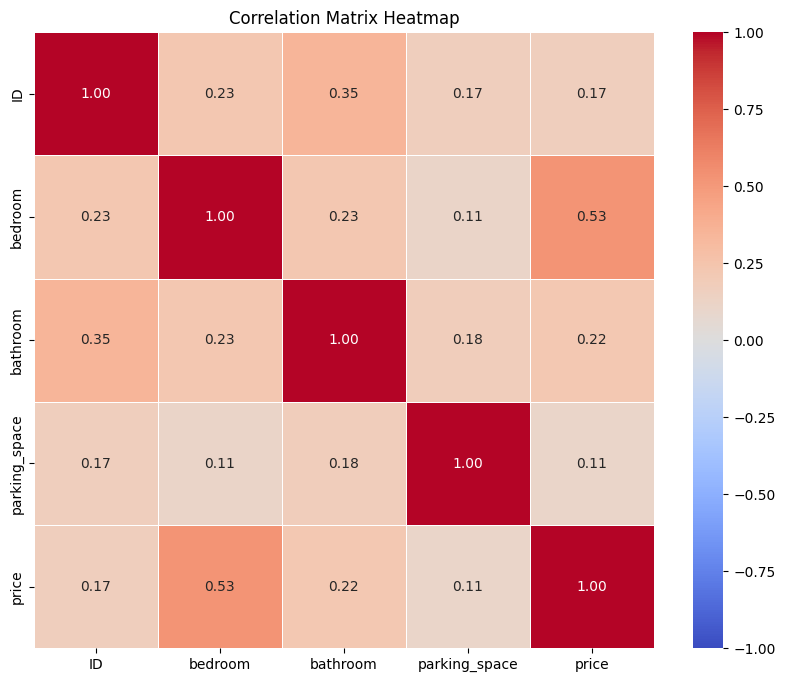

In [ ]:
# Create the correlation matrix
correlation_matrix = train_data.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

The correlation analysis plot shows that
- ``No of bedrooms`` is strongly correlated with the price
- ```No of Bathrooms``` is Positively but weakly correlated with the Price
- ``parking spaces`` is Positively but weakly correlated with the Price

## Visualizing Association Between Independent Variables

###Exploring Distribution of Bedrooms across different house types

In [ ]:
fig = px.box(all_data, x="title", y="bedroom",
             title="Number of Bedrooms by Type of House",
             labels={"type": "Type of House", "bedrooms": "Number of Bedrooms"})
fig.show()

In [ ]:
fig = px.box(all_data, x="title", y="bathroom",
             title="Number of Bathrooms by Type of House",
             labels={"type": "Type of House", "bathroom": "Number of Bathrooms"})
fig.show()

In [ ]:
fig = px.box(all_data, x="title", y="parking_space",
             title="Number of parking spaces by Type of House",
             labels={"type": "Type of House", "bathroparking_spacesom": "Number of parking spaces"})
fig.show()

In [1]:
pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import geopandas as gpd
from sklearn.model_selection import KFold
from xgboost import XGBRFRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import *
from xgboost.sklearn import XGBRegressor


# DATA PROCESSING

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/DSNAIB/Housing_dataset_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/DSNAIB/Housing_dataset_test.csv")


## Combine different the two data together for processing

In [3]:
test_df['price'] = 'test'
total_df = pd.concat([train_df, test_df], axis=0)

In [4]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             20000 non-null  int64  
 1   loc            18187 non-null  object 
 2   title          18278 non-null  object 
 3   bedroom        18201 non-null  float64
 4   bathroom       18195 non-null  float64
 5   parking_space  18189 non-null  float64
 6   price          20000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.2+ MB


## Label Encoding Categorical Variables
- loc and title

In [5]:
total_df['loc'].unique()

array(['Katsina', 'Ondo', 'Ekiti', 'Anambra', 'Kogi', 'Borno', 'Kwara',
       'Osun', 'Kaduna', 'Ogun', 'Bayelsa', nan, 'Abia', 'Rivers',
       'Taraba', 'Ebonyi', 'Kebbi', 'Enugu', 'Edo', 'Nasarawa', 'Delta',
       'Kano', 'Yobe', 'Benue', 'Bauchi', 'Cross River', 'Niger',
       'Adamawa', 'Plateau', 'Imo', 'Oyo', 'Zamfara', 'Sokoto', 'Jigawa',
       'Gombe', 'Akwa Ibom', 'Lagos'], dtype=object)

In [6]:
def get_geopolitical_zone(location):
    north_west = ['Katsina', 'Kano', 'Kaduna', 'Kebbi', 'Sokoto', 'Jigawa', 'Zamfara']
    north_east = ['Borno', 'Yobe', 'Bauchi', 'Adamawa', 'Gombe', 'Taraba']
    north_central = ['Niger', 'Plateau', 'Benue', 'Kwara', 'Nasarawa', 'Kogi']
    south_west = ['Ondo', 'Ekiti', 'Osun', 'Ogun', 'Lagos', 'Oyo']
    south_east = ['Anambra', 'Abia', 'Enugu', 'Ebonyi', 'Imo']
    south_south = ['Bayelsa', 'Rivers', 'Cross River', 'Delta', 'Edo', 'Akwa Ibom']

    if location in north_west:
        return 1
    elif location in north_east:
        return 2
    elif location in north_central:
        return 3
    elif location in south_west:
        return 4
    elif location in south_east:
        return 5
    elif location in south_south:
        return 6
    else:
        return np.nan


In [7]:
total_df.sample(10)

ID        loc           title  bedroom  bathroom  parking_space  \
1757    8486   Nasarawa       Penthouse      5.0       1.0            2.0   
7715    6046    Katsina            Flat      2.0       6.0            5.0   
10662   2038      Lagos  Terrace duplex      1.0       7.0            NaN   
59     11198    Plateau  Terrace duplex      NaN       1.0            1.0   
6136    9554   Nasarawa        Bungalow      NaN       6.0            5.0   
4515    5525  Akwa Ibom        Bungalow      8.0       7.0            1.0   
13265  11507       Ondo            Flat      NaN       3.0            6.0   
1296    8157    Katsina       Apartment      1.0       4.0            2.0   
10343   2148        Oyo  Terrace duplex      NaN       2.0            4.0   
3025    2393        NaN         Mansion      NaN       1.0            3.0   

             price  
1757          test  
7715   1265015.421  
10662  2585965.551  
59     1723753.995  
6136    2612518.16  
4515          test  
13265  2948689.344  
1296   853773.1773  
10343  1755622.903  
3025   1243506.473

In [8]:
le = LabelEncoder()
le.fit(total_df['loc'].dropna().unique())
mapping_loc = dict(zip(le.classes_, le.transform(le.classes_)))
print(len(mapping_loc))

36


In [9]:
le = LabelEncoder()
le.fit(total_df['title'].dropna().unique())
mapping_title = dict(zip(le.classes_, le.transform(le.classes_)))
print(len(mapping_title))


10


In [10]:
total_df.columns

Index(['ID', 'loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')

## Dealing with missing values

In [11]:
total_df.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [12]:
len(total_df.ID.unique())

13000

In [13]:
total_df['bedroom'].std()

2.445599574222024

In [14]:
total_df['bedroom']=total_df['bedroom'].fillna(total_df['bedroom'].std())
total_df['bathroom']=total_df['bathroom'].fillna(total_df['bathroom'].std())
total_df['parking_space']=total_df['parking_space'].fillna(0)

In [15]:
total_df.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom             0
bathroom            0
parking_space       0
price               0
dtype: int64

In [16]:
total_df['bathroom_bedroom'] = total_df['bathroom']/ total_df['bedroom']

In [17]:
total_df.dropna(inplace=True)

In [18]:
total_df['geopolitical_zone'] = total_df['loc'].apply(get_geopolitical_zone)

In [19]:
total_df.isnull().sum()

ID                   0
loc                  0
title                0
bedroom              0
bathroom             0
parking_space        0
price                0
bathroom_bedroom     0
geopolitical_zone    0
dtype: int64

In [20]:
total_df.head()

ID      loc                 title  bedroom  bathroom  parking_space  \
0   3583  Katsina  Semi-detached duplex   2.0000       2.0            1.0   
1   2748     Ondo             Apartment   2.4456       2.0            4.0   
3   2224  Anambra       Detached duplex   5.0000       2.0            4.0   
4  10300     Kogi        Terrace duplex   2.4456       5.0            6.0   
5   1733    Borno               Mansion   2.4456       1.0            3.0   

         price  bathroom_bedroom  geopolitical_zone  
0  1149999.565          1.000000                  1  
1  1672416.689          0.817795                  4  
3  2410306.756          0.400000                  5  
4  2600700.898          2.044488                  3  
5  1341750.867          0.408898                  2

In [21]:
total_df['title'] = total_df['title'].map(mapping_title)
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16531 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 16531 non-null  int64  
 1   loc                16531 non-null  object 
 2   title              16531 non-null  int64  
 3   bedroom            16531 non-null  float64
 4   bathroom           16531 non-null  float64
 5   parking_space      16531 non-null  float64
 6   price              16531 non-null  object 
 7   bathroom_bedroom   16531 non-null  float64
 8   geopolitical_zone  16531 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.3+ MB


In [22]:
total_df.head()

ID      loc  title  bedroom  bathroom  parking_space        price  \
0   3583  Katsina      7   2.0000       2.0            1.0  1149999.565   
1   2748     Ondo      0   2.4456       2.0            4.0  1672416.689   
3   2224  Anambra      3   5.0000       2.0            4.0  2410306.756   
4  10300     Kogi      8   2.4456       5.0            6.0  2600700.898   
5   1733    Borno      5   2.4456       1.0            3.0  1341750.867   

   bathroom_bedroom  geopolitical_zone  
0          1.000000                  1  
1          0.817795                  4  
3          0.400000                  5  
4          2.044488                  3  
5          0.408898                  2

In [23]:
total_df.isnull().sum()

ID                   0
loc                  0
title                0
bedroom              0
bathroom             0
parking_space        0
price                0
bathroom_bedroom     0
geopolitical_zone    0
dtype: int64

In [24]:
# use get_dummies on the columns Gender and Country
tot_data = pd.get_dummies(total_df, columns=["geopolitical_zone", "loc"])

In [25]:
tot_data.head()

ID  title  bedroom  bathroom  parking_space        price  \
0   3583      7   2.0000       2.0            1.0  1149999.565   
1   2748      0   2.4456       2.0            4.0  1672416.689   
3   2224      3   5.0000       2.0            4.0  2410306.756   
4  10300      8   2.4456       5.0            6.0  2600700.898   
5   1733      5   2.4456       1.0            3.0  1341750.867   

   bathroom_bedroom  geopolitical_zone_1  geopolitical_zone_2  \
0          1.000000                    1                    0   
1          0.817795                    0                    0   
3          0.400000                    0                    0   
4          2.044488                    0                    0   
5          0.408898                    0                    1   

   geopolitical_zone_3  ...  loc_Ogun  loc_Ondo  loc_Osun  loc_Oyo  \
0                    0  ...         0         0         0        0   
1                    0  ...         0         1         0        0   
3                    0  ...         0         0         0        0   
4                    1  ...         0         0         0        0   
5                    0  ...         0         0         0        0   

   loc_Plateau  loc_Rivers  loc_Sokoto  loc_Taraba  loc_Yobe  loc_Zamfara  
0            0           0           0           0         0            0  
1            0           0           0           0         0            0  
3            0           0           0           0         0            0  
4            0           0           0           0         0            0  
5            0           0           0           0         0            0  

[5 rows x 49 columns]

In [26]:
tot_data.isnull().sum()

ID                     0
title                  0
bedroom                0
bathroom               0
parking_space          0
price                  0
bathroom_bedroom       0
geopolitical_zone_1    0
geopolitical_zone_2    0
geopolitical_zone_3    0
geopolitical_zone_4    0
geopolitical_zone_5    0
geopolitical_zone_6    0
loc_Abia               0
loc_Adamawa            0
loc_Akwa Ibom          0
loc_Anambra            0
loc_Bauchi             0
loc_Bayelsa            0
loc_Benue              0
loc_Borno              0
loc_Cross River        0
loc_Delta              0
loc_Ebonyi             0
loc_Edo                0
loc_Ekiti              0
loc_Enugu              0
loc_Gombe              0
loc_Imo                0
loc_Jigawa             0
loc_Kaduna             0
loc_Kano               0
loc_Katsina            0
loc_Kebbi              0
loc_Kogi               0
loc_Kwara              0
loc_Lagos              0
loc_Nasarawa           0
loc_Niger              0
loc_Ogun               0


### spliting the data to original train test

In [27]:
tot_data.head()

ID  title  bedroom  bathroom  parking_space        price  \
0   3583      7   2.0000       2.0            1.0  1149999.565   
1   2748      0   2.4456       2.0            4.0  1672416.689   
3   2224      3   5.0000       2.0            4.0  2410306.756   
4  10300      8   2.4456       5.0            6.0  2600700.898   
5   1733      5   2.4456       1.0            3.0  1341750.867   

   bathroom_bedroom  geopolitical_zone_1  geopolitical_zone_2  \
0          1.000000                    1                    0   
1          0.817795                    0                    0   
3          0.400000                    0                    0   
4          2.044488                    0                    0   
5          0.408898                    0                    1   

   geopolitical_zone_3  ...  loc_Ogun  loc_Ondo  loc_Osun  loc_Oyo  \
0                    0  ...         0         0         0        0   
1                    0  ...         0         1         0        0   
3                    0  ...         0         0         0        0   
4                    1  ...         0         0         0        0   
5                    0  ...         0         0         0        0   

   loc_Plateau  loc_Rivers  loc_Sokoto  loc_Taraba  loc_Yobe  loc_Zamfara  
0            0           0           0           0         0            0  
1            0           0           0           0         0            0  
3            0           0           0           0         0            0  
4            0           0           0           0         0            0  
5            0           0           0           0         0            0  

[5 rows x 49 columns]

In [28]:
train_data = tot_data[tot_data['price'] != 'test']
test_data = tot_data[tot_data['price'] == 'test']

In [29]:
train_data.shape, test_data.shape

((10531, 49), (6000, 49))

# DATA MODELLING

## Split training data into train and validation

In [30]:
train_data['price_**2'] = np.sqrt(train_data['price'].astype(float))

<ipython-input-30-1d380f951d40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['price_**2'] = np.sqrt(train_data['price'].astype(float))


In [31]:
X = train_data.drop(['price', 'price_**2'], axis=1)
y = train_data['price_**2']
X_train, X_val, y_train, y_val = train_test_split(X, y)

## Linear Regression

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred_val = lin_reg.predict(X_val)
pred_test = lin_reg.predict(test_data.drop(['price'], axis=1))

print("RMSE : ", mean_squared_error(y_val, pred_val, squared=False))

RMSE :  221.18619480100054


In [33]:
lin_reg = LGBMRegressor()
lin_reg.fit(X_train, y_train.astype(float))

pred_val = lin_reg.predict(X_val)
pred_test = lin_reg.predict(test_data.drop(['price'], axis=1))

print("RMSE : ", mean_squared_error(y_val, pred_val, squared=False))

RMSE :  120.73027853059078


In [44]:
sub_file = pd.DataFrame({
    'ID': test_df.ID,
    'price': pred_test
})

sub_file.to_csv('lrfems.csv', index = False)

## Using Out of Fold Cross Validation

In [43]:
in_cols = train_data.drop(columns=['price', 'price_**2']).columns
in_cols

Index(['ID', 'title', 'bedroom', 'bathroom', 'parking_space',
       'bathroom_bedroom', 'geopolitical_zone_1', 'geopolitical_zone_2',
       'geopolitical_zone_3', 'geopolitical_zone_4', 'geopolitical_zone_5',
       'geopolitical_zone_6', 'loc_Abia', 'loc_Adamawa', 'loc_Akwa Ibom',
       'loc_Anambra', 'loc_Bauchi', 'loc_Bayelsa', 'loc_Benue', 'loc_Borno',
       'loc_Cross River', 'loc_Delta', 'loc_Ebonyi', 'loc_Edo', 'loc_Ekiti',
       'loc_Enugu', 'loc_Gombe', 'loc_Imo', 'loc_Jigawa', 'loc_Kaduna',
       'loc_Kano', 'loc_Katsina', 'loc_Kebbi', 'loc_Kogi', 'loc_Kwara',
       'loc_Lagos', 'loc_Nasarawa', 'loc_Niger', 'loc_Ogun', 'loc_Ondo',
       'loc_Osun', 'loc_Oyo', 'loc_Plateau', 'loc_Rivers', 'loc_Sokoto',
       'loc_Taraba', 'loc_Yobe', 'loc_Zamfara'],
      dtype='object')

In [44]:
ycol = 'price_**2'

In [60]:
kf = KFold(n_splits=6, shuffle=False)

In [61]:
train_data[ycol] = train_data[ycol].astype(float)

<ipython-input-61-fdb2ac611da7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[ycol] = train_data[ycol].astype(float)


In [62]:
scores = []
test_oofs = []
for train, test in kf.split(X = train_data[in_cols],y=train_data[ycol]):

    cat = LGBMRegressor(n_estimators=4000, metric='rmse', learning_rate=0.01, subsample_freq =1, reg_alpha=5)

    cat.fit(train_data[in_cols].iloc[train], train_data[ycol].iloc[train],eval_set=[(train_data[in_cols].iloc[test], train_data[ycol].iloc[test])], early_stopping_rounds=300, verbose=100)

    rmse = mean_squared_error(train_data[ycol].iloc[test], cat.predict(train_data[in_cols].iloc[test]), squared=False)

    predictions = cat.predict(test_data[in_cols])
    test_oofs.append(predictions)
    scores.append(rmse)
    print(rmse)

print("Average score in 5-fold CV:", np.mean(scores))

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 206.412
[200]	valid_0's rmse: 161.059
[300]	valid_0's rmse: 139.648
[400]	valid_0's rmse: 128.963
[500]	valid_0's rmse: 123.563
[600]	valid_0's rmse: 120.864
[700]	valid_0's rmse: 119.384
[800]	valid_0's rmse: 118.558
[900]	valid_0's rmse: 118.174
[1000]	valid_0's rmse: 117.843
[1100]	valid_0's rmse: 117.809
[1200]	valid_0's rmse: 117.857
[1300]	valid_0's rmse: 117.885
117.75199455909006
[100]	valid_0's rmse: 193.245


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's rmse: 149.181
[300]	valid_0's rmse: 130.399
[400]	valid_0's rmse: 122.002
[500]	valid_0's rmse: 118.326
[600]	valid_0's rmse: 116.673
[700]	valid_0's rmse: 115.771
[800]	valid_0's rmse: 115.356
[900]	valid_0's rmse: 115.33
[1000]	valid_0's rmse: 115.436
[1100]	valid_0's rmse: 115.519
115.32629561735432


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 182.125
[200]	valid_0's rmse: 139.783
[300]	valid_0's rmse: 121.487
[400]	valid_0's rmse: 112.862
[500]	valid_0's rmse: 109.358
[600]	valid_0's rmse: 107.739
[700]	valid_0's rmse: 106.8
[800]	valid_0's rmse: 106.455
[900]	valid_0's rmse: 106.382
[1000]	valid_0's rmse: 106.295
[1100]	valid_0's rmse: 106.33
[1200]	valid_0's rmse: 106.341
[1300]	valid_0's rmse: 106.315
106.28568549706718
[100]	valid_0's rmse: 197.291


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's rmse: 155.89
[300]	valid_0's rmse: 138.171
[400]	valid_0's rmse: 130.09
[500]	valid_0's rmse: 126.116
[600]	valid_0's rmse: 124.477
[700]	valid_0's rmse: 123.774
[800]	valid_0's rmse: 123.323
[900]	valid_0's rmse: 123.094
[1000]	valid_0's rmse: 122.834
[1100]	valid_0's rmse: 122.776
[1200]	valid_0's rmse: 122.75
[1300]	valid_0's rmse: 122.698
[1400]	valid_0's rmse: 122.633
[1500]	valid_0's rmse: 122.628
[1600]	valid_0's rmse: 122.757
[1700]	valid_0's rmse: 122.848
122.59366584459092
[100]	valid_0's rmse: 204.69


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's rmse: 159.187
[300]	valid_0's rmse: 139.173
[400]	valid_0's rmse: 130.392
[500]	valid_0's rmse: 126.267
[600]	valid_0's rmse: 124.626
[700]	valid_0's rmse: 123.499
[800]	valid_0's rmse: 122.844
[900]	valid_0's rmse: 122.505
[1000]	valid_0's rmse: 122.529
[1100]	valid_0's rmse: 122.568
[1200]	valid_0's rmse: 122.787
122.47599464291297
[100]	valid_0's rmse: 198.401


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's rmse: 154.334
[300]	valid_0's rmse: 136.07
[400]	valid_0's rmse: 128.18
[500]	valid_0's rmse: 125.068
[600]	valid_0's rmse: 123.746
[700]	valid_0's rmse: 123.021
[800]	valid_0's rmse: 122.609
[900]	valid_0's rmse: 122.297
[1000]	valid_0's rmse: 122.176
[1100]	valid_0's rmse: 122.188
[1200]	valid_0's rmse: 122.256
[1300]	valid_0's rmse: 122.198
122.16978872618603


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 199.632
[200]	valid_0's rmse: 156.773
[300]	valid_0's rmse: 136.602
[400]	valid_0's rmse: 126.142
[500]	valid_0's rmse: 120.627
[600]	valid_0's rmse: 117.746
[700]	valid_0's rmse: 116.004
[800]	valid_0's rmse: 114.954
[900]	valid_0's rmse: 114.376
[1000]	valid_0's rmse: 113.989
[1100]	valid_0's rmse: 113.709
[1200]	valid_0's rmse: 113.514
[1300]	valid_0's rmse: 113.335
[1400]	valid_0's rmse: 113.3
[1500]	valid_0's rmse: 113.299
[1600]	valid_0's rmse: 113.292
[1700]	valid_0's rmse: 113.325
113.27143769992362
Average score in 5-fold CV: 117.1249803695893


In [63]:
test_price = np.mean(test_oofs,axis=0)

sub_file = pd.DataFrame({
    'ID': test_df.ID,
    'price': test_price**2
})

sub_file.to_csv('lgb7dropprocpricesqrtparams.csv', index = False)

In [51]:
scores = []
test_oofs = []
for train, test in kf.split(X = train_data[in_cols],y=train_data[ycol]):

    cat = CatBoostRegressor()

    cat.fit(train_data[in_cols].iloc[train], train_data[ycol].iloc[train],eval_set=[(train_data[in_cols].iloc[test], train_data[ycol].iloc[test])], early_stopping_rounds=300, verbose=100)

    rmse = mean_squared_error(train_data[ycol].iloc[test], cat.predict(train_data[in_cols].iloc[test]), squared=False)

    predictions = cat.predict(test_data[in_cols])
    test_oofs.append(predictions)
    scores.append(rmse)
    print(rmse)

print("Average score in 5-fold CV:", np.mean(scores))

Learning rate set to 0.071154
0:	learn: 1011463.9242640	test: 1055375.2452224	best: 1055375.2452224 (0)	total: 49.8ms	remaining: 49.7s
100:	learn: 417878.3398582	test: 460800.9395518	best: 460800.9395518 (100)	total: 258ms	remaining: 2.3s
200:	learn: 378772.1208817	test: 433160.6752561	best: 433160.6752561 (200)	total: 461ms	remaining: 1.83s
300:	learn: 349625.8496016	test: 425936.7682531	best: 425850.0228953 (281)	total: 674ms	remaining: 1.56s
400:	learn: 329481.5938223	test: 425440.9686809	best: 424659.8157595 (337)	total: 900ms	remaining: 1.34s
500:	learn: 314587.0366669	test: 425702.3878741	best: 424659.8157595 (337)	total: 1.13s	remaining: 1.13s
600:	learn: 302232.4367602	test: 425877.8912127	best: 424450.0358073 (525)	total: 1.33s	remaining: 886ms
700:	learn: 291785.4237945	test: 428255.3010352	best: 424450.0358073 (525)	total: 1.55s	remaining: 663ms
800:	learn: 282149.0923761	test: 430825.3068998	best: 424450.0358073 (525)	total: 1.77s	remaining: 441ms
Stopped by overfitting det

In [52]:
test_price = np.mean(test_oofs,axis=0)

sub_file = pd.DataFrame({
    'ID': test_df.ID,
    'price': test_price
})

sub_file.to_csv('cat5dropproc.csv', index = False)

In [ ]:
sub_file

ID      price
0       845  39.061281
1      1924  31.774404
2     10718  33.623185
3     12076  53.282070
4     12254  36.755446
...     ...        ...
5995   1594  37.047443
5996   2416  37.433694
5997  10195  37.501140
5998   9455  35.771705
5999  11736  43.588983

[6000 rows x 2 columns]

In [ ]:
test_data.shape

(6000, 51)

In [ ]:
test_data

ID   loc  title  bedroom  bathroom  parking_space         price
14000 NaN  18.0    6.0      4.0       1.0            2.0  2.264429e+06
14001 NaN   1.0    0.0      2.0       2.0            4.0  1.010941e+06
14002 NaN   1.0    1.0      2.0       7.0            2.0  1.196163e+06
14003 NaN  23.0    5.0      9.0       5.0            2.0  7.326677e+06
14004 NaN  14.0    7.0      5.0       6.0            1.0  1.981618e+06
...    ..   ...    ...      ...       ...            ...           ...
19995 NaN  12.0    4.0      4.0       5.0            2.0  1.750208e+06
19996 NaN   1.0    8.0      5.0       7.0            1.0  2.042708e+06
19997 NaN  29.0    9.0      4.0       1.0            4.0  1.905337e+06
19998 NaN   4.0    4.0      3.0       7.0            5.0  1.521173e+06
19999 NaN  32.0    5.0      6.0       1.0            6.0  3.432169e+06

[6000 rows x 7 columns]